In [ ]:
# Mount google drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Import Libraries

In [ ]:
# Image processing
import os
import PIL
from PIL import Image

# Analysis
import numpy as np
import pandas as pd
from datetime import datetime
from collections import Counter

# Visualisations
import matplotlib.pyplot as plt
import seaborn as sns

# Model Training
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import Sequential, Input, Model, layers
from tensorflow.keras.layers import Dense, Flatten, Rescaling, Dropout, Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import plot_model

In [ ]:
# Evaluation
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score, auc

# Load Kaggle Dataset

In [ ]:
!pip install kaggle

Assigned constants such as the input shape, the number of classes, the number of epochs, batch size and learning rate for model training.

In [ ]:
# CONSTANTS
DATA_DIR = '/content/dataset'
IMG_HEIGHT = 100
IMG_WIDTH = 100
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
BATCH_SIZE = 64
EPOCHS = 30
LEARNING_RATE = 0.001
NUM_CLASSES = 10

# CONSTANTS
landuse_dict = {
    'highdensitybuildings':0,
    'lowdensitybuildings':1,
    'roads':2,
    'recreational':3,
    'harbor':4,
    'beach':5,
    'forest':6,
    'river':7,
    'runway':8,
    'storagetanks':9,
}
CLASSES = list(landuse_dict.keys())
NUM_CLASSES = len(CLASSES)

In [ ]:
if not os.path.exists(DATA_DIR):
  # Create directory to store kaggle credentials
  !mkdir ~/.kaggle
  # Add kaggle.json file in your root folder
  !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
  # Set Permissions
  !chmod 600 ~/.kaggle/kaggle.json
  # Download dataset
  !kaggle datasets download -d racheltanminzhi/landuse
  # Unzip folder
  !unzip /content/landuse.zip -d /content/dataset/
else:
  print('Directory already exists.')

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/recreational/recreational_00502.png  
  inflating: /content/dataset/recreational/recreational_00503.png  
  inflating: /content/dataset/recreational/recreational_00504.png  
  inflating: /content/dataset/recreational/recreational_00505.png  
  inflating: /content/dataset/recreational/recreational_00506.png  
  inflating: /content/dataset/recreational/recreational_00507.png  
  inflating: /content/dataset/recreational/recreational_00508.png  
  inflating: /content/dataset/recreational/recreational_00509.png  
  inflating: /content/dataset/recreational/recreational_00510.png  
  inflating: /content/dataset/recreational/recreational_00511.png  
  inflating: /content/dataset/recreational/recreational_00512.png  
  inflating: /content/dataset/recreational/recreational_00513.png  
  inflating: /content/dataset/recreational/recreational_00514.png  
  inflating: /content/dataset/recreational/recreational_00515.png

In [ ]:
# Fucntion creates the feature (X) and target (y) datasets based on the given file directory
def create_ds(directory):
    file_names = []
    y = []
    for root, directories, files in os.walk(directory):
        for file in files:
            y.append(landuse_dict[root.split('/')[-1]])
            file_names.append(os.path.join(root, file))
    X = np.stack([(Image.open(file)).resize((100, 100)) for file in file_names])
    y = np.array(y).reshape(-1, 1)
    return X, y

In [ ]:
# Create the feature (X) and target (y) datasets from the combined landuse dataset
X, y = create_ds('/content/dataset')

In [ ]:
# Split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Functions

In [ ]:
# Plots the AUCROC curve for each class
def getAUCROC(predprob):

    auc_score = {}
    fpr = {}
    tpr = {}
    thresh ={}

    n_class = 10

    for i in range(n_class):
        fpr[i], tpr[i], thresh[i] = roc_curve(y_testOrg, predprob[:,i], pos_label=i)
        auc_score[i] = auc(fpr[i], tpr[i])

    # plotting
    plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='0 highdensitybuildings')
    plt.plot(fpr[1], tpr[1], linestyle='--',color='slategrey', label='1 lowdensitybuildings')
    plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='2 roads')
    plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='3 recreational')
    plt.plot(fpr[4], tpr[4], linestyle='--',color='pink', label='4 harbor')
    plt.plot(fpr[5], tpr[5], linestyle='--',color='cyan', label='5 beach')
    plt.plot(fpr[6], tpr[6], linestyle='--',color='green', label='6 forest')
    plt.plot(fpr[7], tpr[7], linestyle='--',color='skyblue', label='7 river')
    plt.plot(fpr[8], tpr[8], linestyle='--',color='sienna', label='8 runway')
    plt.plot(fpr[9], tpr[9], linestyle='--',color='purple', label='9 storagetanks')
    plt.title('Multiclass ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc='best')

    print("AUC scores:")
    for i in range(n_class):
        print(i, auc_score[i])

In [ ]:
# Calculates the confidence levels
def conf_levels(predprob, predclass):
  # Set a condition to filter for records that were incorrectly predicted
  condition = (predclass != y_testOrg)

  # Get the highest percentage out of all classes
  confidence = np.max(predprob, axis=1)

  # Filter for records that were incorrectly predicted
  incorrect_confidence = confidence[condition]

  # Store values in a list
  mean_confidence = []
  for num in range(0, 10):
    # Calculate average confidence of model in its predictions
    mean_val = np.mean(confidence[y_testOrg == num])
    mean_confidence.append(f'{mean_val*100:.2f}%')

  # Create a dataframe to display values
  class_names = pd.Series(CLASSES)
  mean_confidence = pd.Series(mean_confidence)
  df_confidence = pd.concat([class_names, mean_confidence], axis=1)
  df_confidence.columns = ['Class', 'Confidence Level']
  df_confidence.sort_values('Confidence Level', ascending = False)

  ## For plotting incorrectly predicted image samples
  # Actual class of records for incorrectly classified samples
  true_class = y_testOrg[condition]
  # Incorrectly predicted class
  incorrect_pred = predclass[condition]

  # Filter for incorrect val images
  X_test_incorrect = X_test[condition]
  X_test_incorrect = X_test_incorrect.reshape(incorrect_pred.shape[0], 100, 100, 3)

  # Define number of samples
  num_samples = 30
  # Choose samples randomly
  random_idxpred = np.random.choice(incorrect_pred.shape[0], num_samples, replace=False)

  # Plot samples
  fig, axes = plt.subplots(5, 5, figsize=(15, 15))
  fig.suptitle('Predicted vs Actual Class Labels', size = 20,  y = 1.05)

  for idx, ax in zip(random_idxpred, axes.flatten()):
    ax.imshow(X_test_incorrect[idx], cmap='gray')
    ax.set_title(f'Actual: {CLASSES[true_class[idx]]}\nPredicted: {CLASSES[incorrect_pred[idx]]}\
      \n({incorrect_confidence[idx]*100:.2f}%)', color='red')
    ax.axis('off')
  plt.tight_layout()
  plt.show()

  return df_confidence


In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred_classes):
    # compute the confusion matrix
    confusion_mtx = confusion_matrix(y_true, y_pred_classes)

    # plot the confusion matrix
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap='Blues', linecolor='gray', fmt= '.1f', ax=ax)
    plt.xlabel('Predicted Label', size = 16)
    plt.ylabel('True Label', size = 16)
    plt.title('Confusion Matrix', size = 20)
    plt.show()

# Feature Engineering

No. of records in train data: 7600<br>
No. of records in test data: 1901<br>
Dimensions of original images: 256 x 256<br>
Dimensions of resized images used in training: 100 x 100<br>

In [ ]:
X_train = X_train/255.0
X_test = X_test/255.0

In [ ]:
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)
print(y_train.shape)
print(y_test.shape)

(7600, 10)
(1901, 10)


Before training the baseline model, we split the current train dataset (using scikit-learn's train_test_split method) further into train and validation datasets. We will use the validation sets to assess the model's performance during training.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

<a id='Augmentation'></a>
## Data Augmentation
We used data augmentation to synthetically create more images by modifying current data to improve model prediction accuracy. With an increase in data, the model is forced to generalise and this helps to reduce overfitting.

 These transformations create variations of the original images, making the model more unchanging when it comes to changes such as orientation. This also introduces variability and more realistic scenarios, helping the model to learn more robust and generalizable features which can be applied to unseen data.

In [ ]:
datagen = ImageDataGenerator(
    rotation_range = 5, # Randomly rotate images in the range by 5 degrees
    zoom_range = 0.1, # Randomly zoom image by 10%
    shear_range = 0.3, # Shear angle in counter-clockwise direction in degrees by 30%
    width_shift_range = 0.1, # randomly shift images horizontally by 10%
    height_shift_range = 0.1, # randomly shift images vertically by 10%
)

# Comparison with other CNN Models

## Comparison with Inception V3

In order to verify the performance of our CNN model, we decided to make use of pre-trained models and test them on the landuse dataset. For this task, we chose the Inception V3 model and ResNet50 model. <br><br>

Inception V3 is an image recognition model that was based on the paper  "Rethinking the Inception Architecture for Computer Vision" by Szegedy, et. al. Its model architecture is as follows:
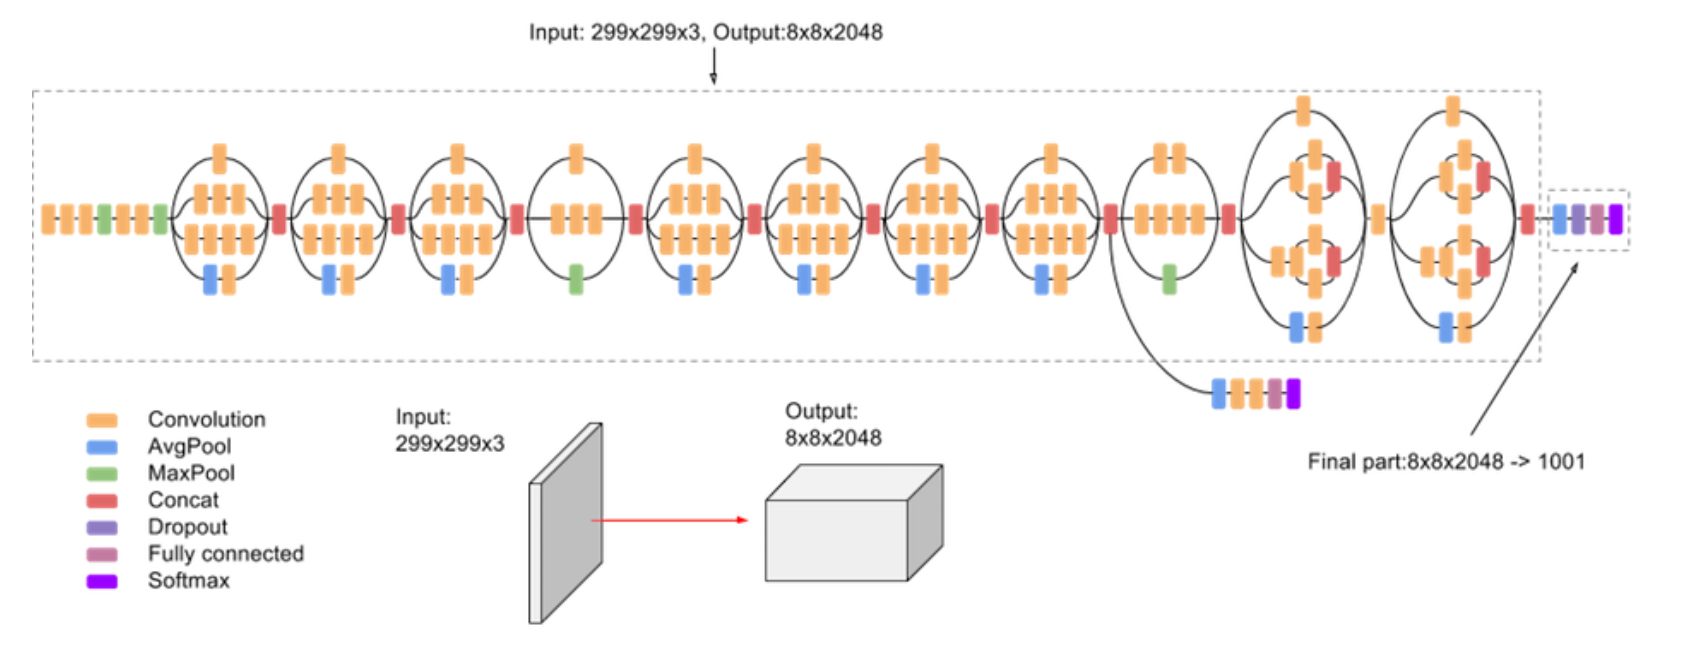

Image source: https://cloud.google.com/tpu/docs/inception-v3-advanced <br><br>

The inceptionV3 model from the Keras API is used. Its weights were pre-trained on ImageNet. <br><br>

Sources:<br>
https://keras.io/api/applications/inceptionv3/<br>https://keras.io/api/applications/#usage-examples-for-image-classification-models

### Model setup and training

In [ ]:
from keras.applications.inception_v3 import InceptionV3

In [ ]:
## train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers

def base_model(inputs):
  base_model = InceptionV3(input_shape=(100, 100, 3), weights='imagenet', include_top=False)
  for layer in base_model.layers:
    layer.trainable = False
  base_model = InceptionV3(input_shape=(100, 100, 3), weights='imagenet', include_top=False)(inputs)
  return base_model

def resnet_classifier(inputs):
    x = GlobalAveragePooling2D()(inputs)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x = Dense(NUM_CLASSES, activation='softmax', name='Output')(x)
    return x

def resize_model(inputs):
    inputs = tf.keras.applications.inception_v3.preprocess_input(inputs)
    resize = tf.image.resize(inputs, size=(100, 100), method=tf.image.ResizeMethod.BILINEAR)
    base_modelV3 = base_model(resize)
    classification_output = resnet_classifier(base_modelV3)
    return classification_output

def compile_model():
    inputs = Input(shape=INPUT_SHAPE)
    classification_output = resize_model(inputs)
    IV3_model = Model(inputs=inputs, outputs = classification_output)
    IV3_model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics = ['accuracy'])
    return IV3_model

IV3_model = compile_model()

# Summary of model
IV3_model.summary()

87910968/87910968 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 100, 100, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 100, 100, 3)       0         
 da)                                                             
                                                                 
 tf.image.resize (TFOpLambd  (None, 100, 100, 3)       0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 1, 1, 2048)        2180278

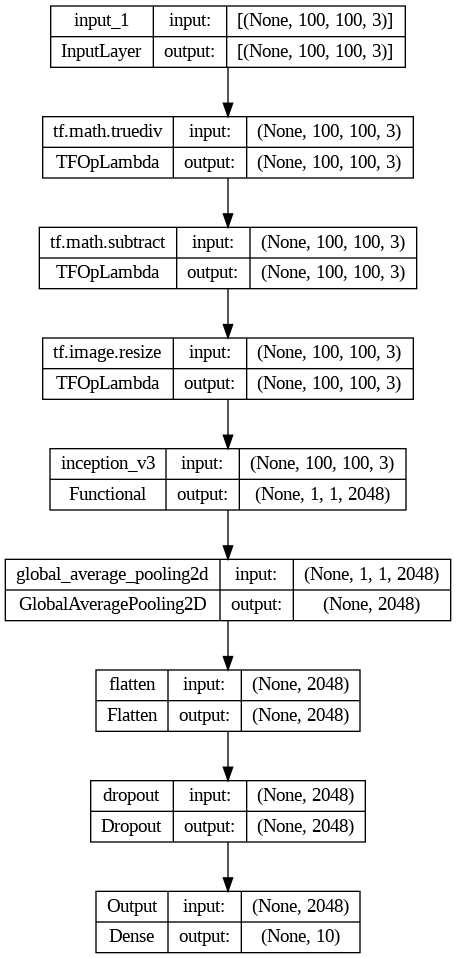

In [ ]:
# Plot graphical summary of the resnet50 model
IV3_model_plot = plot_model(IV3_model, to_file='IV3_model_plot.png', show_shapes=True)
display(IV3_model_plot)

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=10),
             ModelCheckpoint('checkpoints/', monitor='val_loss'),
             ReduceLROnPlateau(monitor='val_accuracy')]

In [ ]:
historyIV3 = IV3_model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE), epochs=10, validation_data = (X_val, y_val), callbacks=callbacks)

Epoch 1/10
95/95 [==============================] - 85s 578ms/step - loss: 1.5427 - accuracy: 0.4803 - val_loss: 0.9164 - val_accuracy: 0.7539 - lr: 0.0100
Epoch 2/10
95/95 [==============================] - 51s 538ms/step - loss: 0.6524 - accuracy: 0.7924 - val_loss: 0.4483 - val_accuracy: 0.8691 - lr: 0.0100
Epoch 3/10
95/95 [==============================] - 53s 562ms/step - loss: 0.3970 - accuracy: 0.8785 - val_loss: 0.3193 - val_accuracy: 0.9020 - lr: 0.0100
Epoch 4/10
95/95 [==============================] - 51s 542ms/step - loss: 0.2747 - accuracy: 0.9125 - val_loss: 0.2677 - val_accuracy: 0.9099 - lr: 0.0100
Epoch 5/10
95/95 [==============================] - 51s 538ms/step - loss: 0.2081 - accuracy: 0.9354 - val_loss: 0.2207 - val_accuracy: 0.9263 - lr: 0.0100
Epoch 6/10
95/95 [==============================] - 51s 535ms/step - loss: 0.1608 - accuracy: 0.9470 - val_loss: 0.1767 - val_accuracy: 0.9395 - lr: 0.0100
Epoch 7/10
95/95 [==============================] - 53s 560ms/st

In [ ]:
IV3_model.save('./landuse_inceptionv3.keras')

## Comparison with ResNet50

ResNet50 is a 50-layer CNN with 48 convolutional layers, one maxpool layer, and one average pool layer. It was initially developed by He Kaiming, Zhang Xiangyu, Ren Shaoqing, and Sun Jian and introduced in the 2015 paper “Deep Residual Learning for Image Recognition” .

### Model setup and training

In [ ]:
def feature_extractor(inputs):
    feature_extractor = ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')(inputs)
    return feature_extractor

def resnet_classifier(inputs):
    x = GlobalAveragePooling2D()(inputs)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x = Dense(NUM_CLASSES, activation='softmax', name='Output')(x)
    return x

def resize_model(inputs):
    resize = tf.image.resize(inputs, size=(224, 224), method=tf.image.ResizeMethod.BILINEAR)
    resnet_feature_extractor = feature_extractor(resize)
    classification_output = resnet_classifier(resnet_feature_extractor)
    return classification_output

def compile_model():
    inputs = Input(shape=INPUT_SHAPE)
    classification_output = resize_model(inputs)
    resnet_model = Model(inputs=inputs, outputs = classification_output)
    resnet_model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics = ['accuracy'])
    return resnet_model
resnet_model = compile_model()

# Summary of model
resnet_model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 tf.image.resize_1 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                            

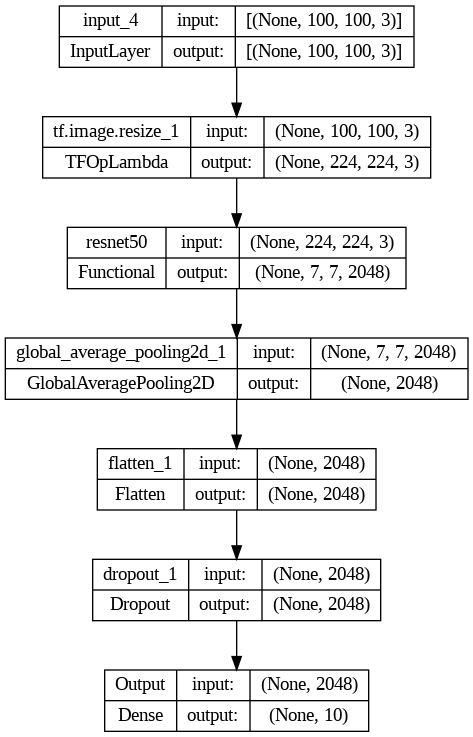

In [ ]:
# Plot graphical summary of the resnet50 model
resnet50_model_plot = plot_model(resnet_model, to_file='resnet_model.png', show_shapes=True)
display(resnet50_model_plot)

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=12),
             ModelCheckpoint('checkpoints/', monitor='val_loss'),
             ReduceLROnPlateau(monitor='val_accuracy')]

In [ ]:
history = resnet_model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE), epochs=10, validation_data = (X_val, y_val), callbacks=callbacks)

Epoch 1/10
95/95 [==============================] - 118s 964ms/step - loss: 0.7827 - accuracy: 0.7513 - val_loss: 0.3902 - val_accuracy: 0.8658 - lr: 0.0100
Epoch 2/10
95/95 [==============================] - 87s 921ms/step - loss: 0.1928 - accuracy: 0.9411 - val_loss: 0.1613 - val_accuracy: 0.9566 - lr: 0.0100
Epoch 3/10
95/95 [==============================] - 85s 900ms/step - loss: 0.1029 - accuracy: 0.9706 - val_loss: 0.1054 - val_accuracy: 0.9599 - lr: 0.0100
Epoch 4/10
95/95 [==============================] - 86s 901ms/step - loss: 0.0602 - accuracy: 0.9873 - val_loss: 0.0757 - val_accuracy: 0.9711 - lr: 0.0100
Epoch 5/10
95/95 [==============================] - 87s 919ms/step - loss: 0.0416 - accuracy: 0.9896 - val_loss: 0.0699 - val_accuracy: 0.9770 - lr: 0.0100
Epoch 6/10
95/95 [==============================] - 87s 914ms/step - loss: 0.0347 - accuracy: 0.9918 - val_loss: 0.1189 - val_accuracy: 0.9638 - lr: 0.0100
Epoch 7/10
95/95 [==============================] - 86s 905ms/s

In [ ]:
resnet_model.save('./landuse_resnet50.keras')

## Inception V3 and ResNet50 combined model evaluation

### Preparation

In [ ]:
# List of models
model_names = ['ResNet50', 'InceptionV3']
models = [resnet_model, IV3_model]
# List of history
model_hist = [history, historyIV3]
# Create a dictionary to map the model to its index
model_dict = {}
for i, model in enumerate(model_names):
  model_dict[model] = i
model_dict

{'ResNet50': 0, 'InceptionV3': 1}

In [ ]:
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis = 1)

### Evaluation

In [ ]:
# Evaluates and displays model metrics

def get_metrics(models):
  metrics_list = []
  pred_list = []
  predproba_list = []
  for model in models:
    # Predict the values from the validation dataset
    y_pred = model.predict(X_test, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis = 1)

    # Get accuracy precision, recall, f1 score, roc-auc score
    acc = model.evaluate(X_test, y_test, verbose=0)
    precision = precision_score(y_true, y_pred_classes, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred_classes, average='weighted')
    f1 = f1_score(y_true, y_pred_classes, average='weighted')
    rocauc = roc_auc_score(y_true, y_pred, multi_class='ovr')
    metrics_list.append([acc[1]*100, precision, recall, f1, rocauc])
    pred_list.append(y_pred_classes)
    predproba_list.append(y_pred)
  return metrics_list, pred_list, predproba_list

# Create a dataframe of metrics
metrics, predictions, predprobas = get_metrics(models)
df_metrics = pd.DataFrame(metrics)
df_metrics.rename(index={0:'ResNet50', 1:'InceptionV3'},
                  columns={0:'Accuracy', 1:'Precision', 2:'Recall', 3:'F1 Score', 4:'ROC AUC'},
                  inplace=True)
df_metrics

Accuracy  Precision    Recall  F1 Score   ROC AUC
ResNet50     97.211993   0.972568  0.972120  0.971991  0.999452
InceptionV3  95.476067   0.955231  0.954761  0.954821  0.998396

In [ ]:
# plots training histories
def plot_traininghist(model, name):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))
    # Title
    fig.suptitle(f'{name}', size=18, fontweight='bold', y=1.05)

    # Accuracy
    sns.lineplot(model.history['accuracy'], ax=axes[0], color='#1338BE', label = 'Train')
    sns.lineplot(model.history['val_accuracy'], ax=axes[0], color='#FF7420', label = 'Validation')

    axes[0].set_title(f'Accuracy per epoch', fontsize=14, fontweight="bold", loc="left", pad=18)
    axes[0].set_xticks(range(0, EPOCHS+1))
    axes[0].set(xlim=(0, 12))

    # Loss
    sns.lineplot(model.history['loss'], ax=axes[1], color='#7734EA', label = 'Train')
    sns.lineplot(model.history['val_loss'], ax=axes[1], color='#FC123E', label = 'Validation')

    axes[1].set_title(f'Loss per epoch', fontsize=14, fontweight="bold", loc="left", pad=18)
    axes[1].set_xticks(range(0, EPOCHS+1))
    axes[1].set(xlim=(0, 12))

    sns.despine(top=True, right=True)
    plt.show()

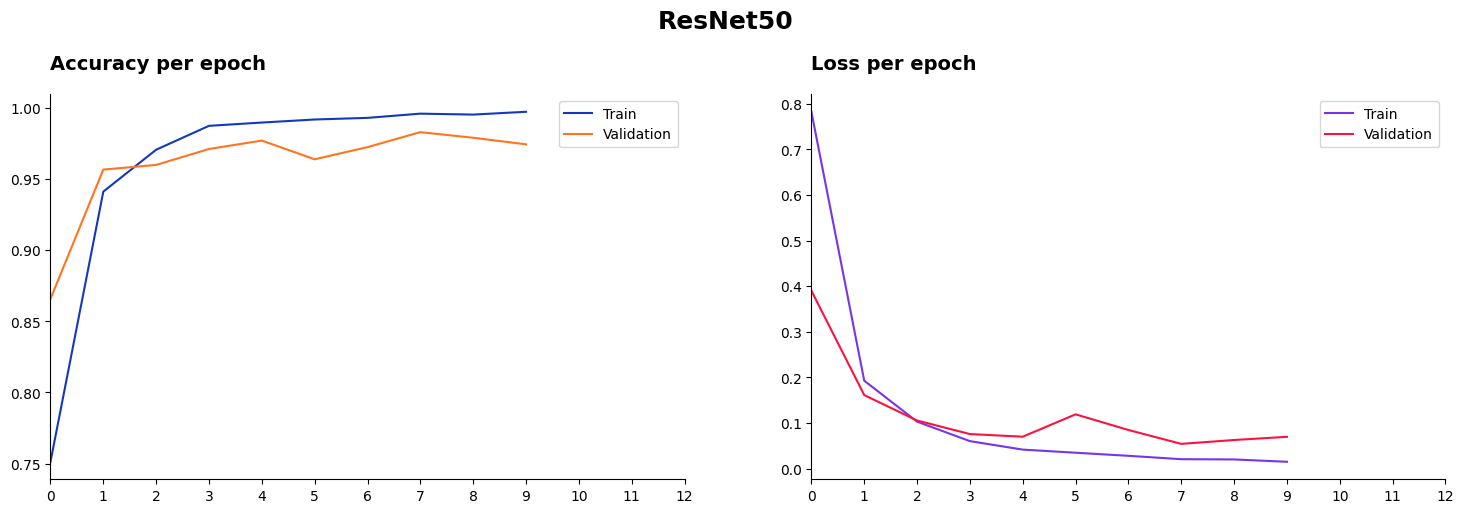

In [ ]:
plot_traininghist(model_hist[model_dict['ResNet50']], 'ResNet50')

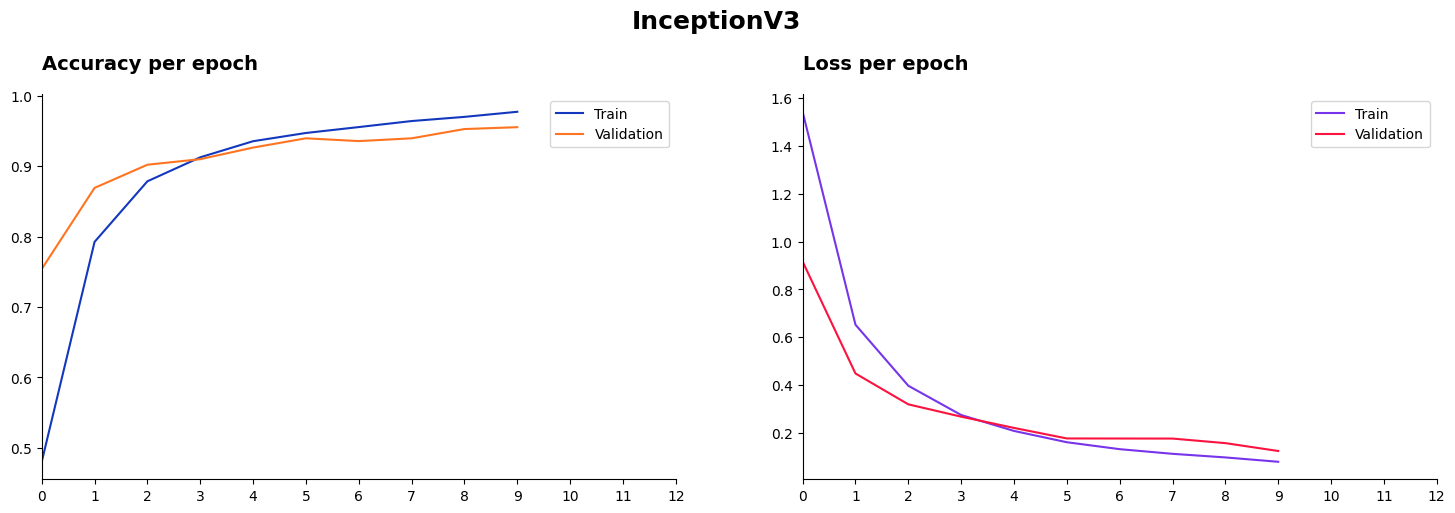

In [ ]:
plot_traininghist(model_hist[model_dict['InceptionV3']], 'InceptionV3')

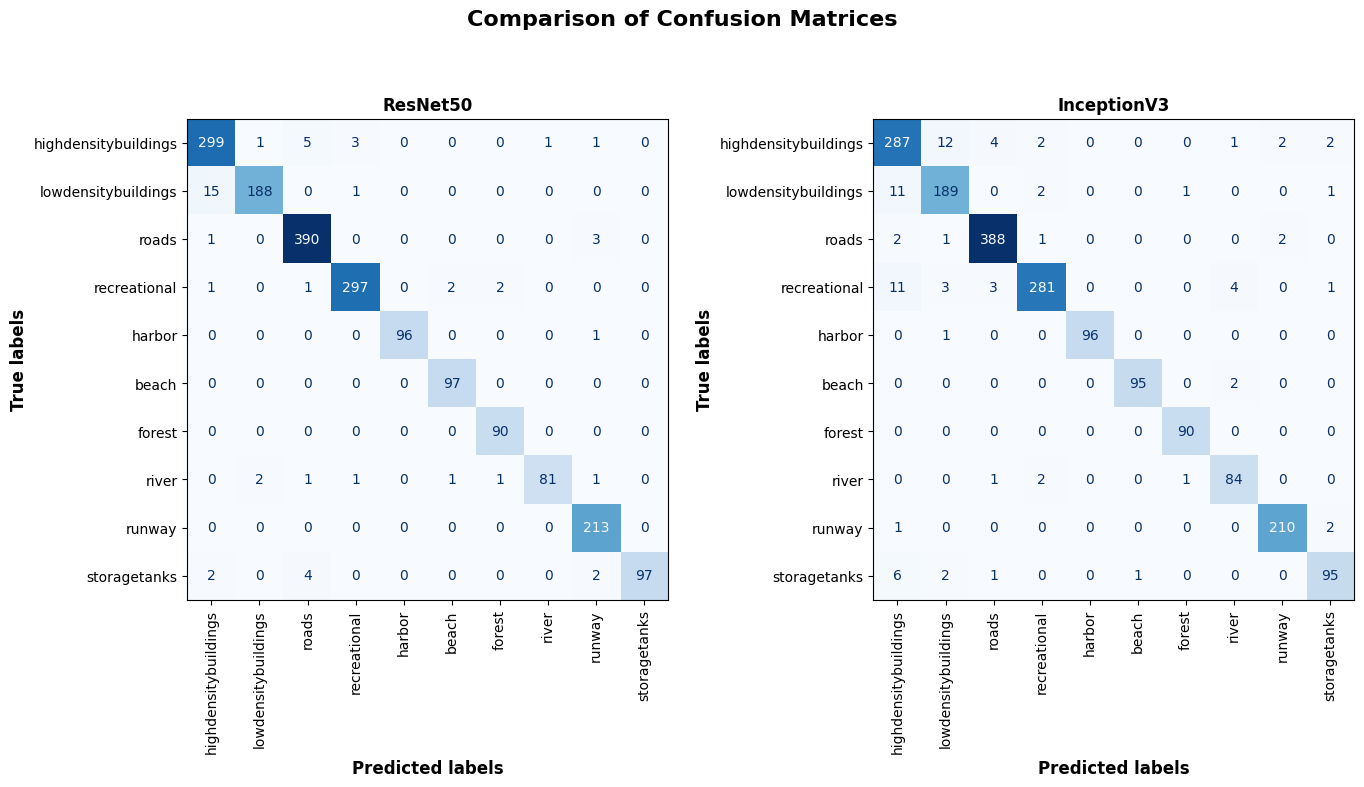

In [ ]:
#plots confusion matrix

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 8))
fig.suptitle('Comparison of Confusion Matrices', size=16, fontweight='bold')
for name, model, y_pred, ax in zip(model_names, models, predictions, axes.flatten()):
    # Plot confusion matrix
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, ax=ax, cmap='Blues', colorbar=False, display_labels=CLASSES)
    # Set title as the model's name
    ax.set_title(name, size=12, fontweight='bold')
    # Change label and tick labels size
    ax.set_xlabel('Predicted labels', size=12, fontweight='bold')
    ax.set_ylabel('True labels', size=12, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xticklabels(CLASSES, rotation=90)
fig.tight_layout(pad = 2.0)
plt.show()

ResNet50 seems to have a slightly better accuracy score of 97.2% compared to Inception V3, which has an accuracy score of 95.5%. Their AUCROC scores are very, very close, with a small difference of 0.00105. This indicates that both models can perform exceptionally at land use classification.

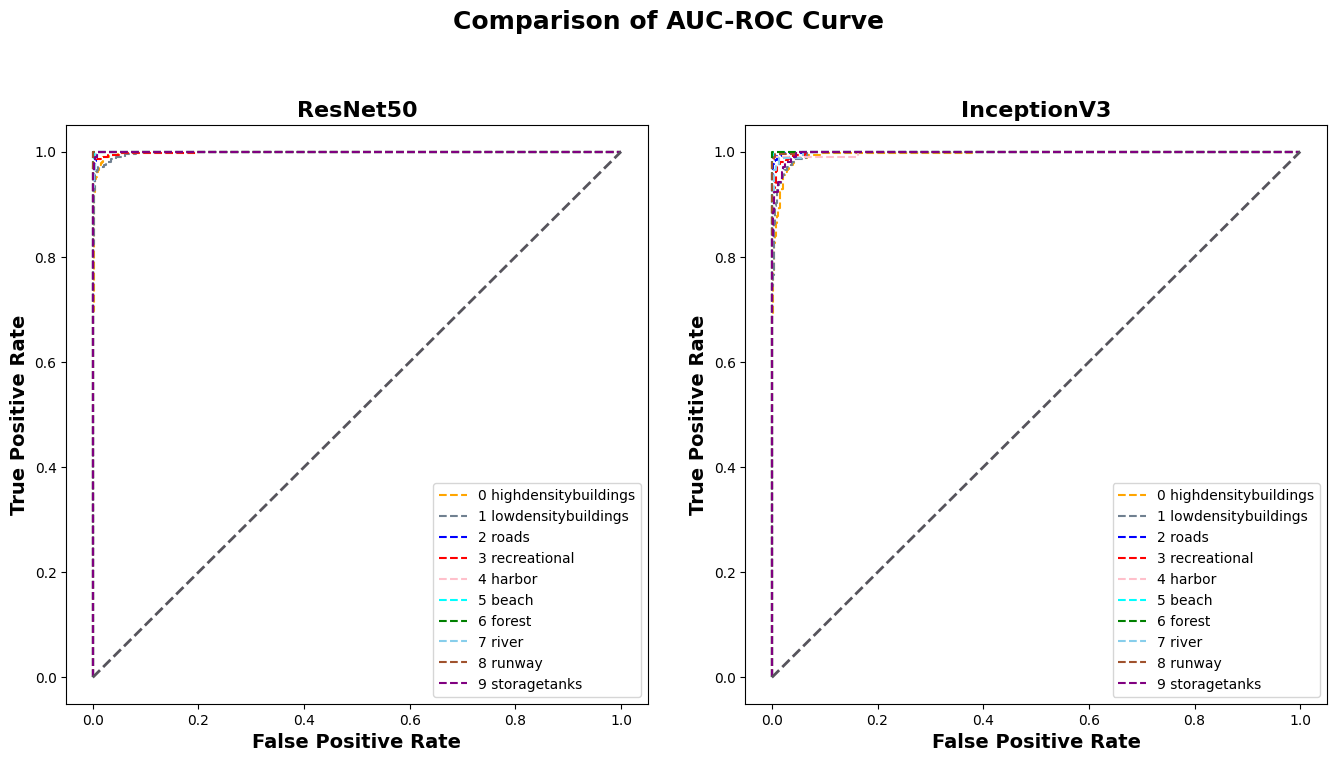

In [ ]:
# Plot AUCROC score
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 8))
fig.suptitle('Comparison of AUC-ROC Curve', size=18, fontweight='bold')
auc_list = []
for name, model, y_prob, ax in zip(model_names, models, predprobas, axes.flatten()):
    auc_score = {}
    fpr = {}
    tpr = {}
    thresh ={}

    # compute roc by passing in the actual and predicted values
    for i in range(NUM_CLASSES):
        fpr[i], tpr[i], thresh[i] = roc_curve(y_true, y_prob[:,i], pos_label=i)
        auc_score[i] = auc(fpr[i], tpr[i])

    auc_list.append(auc_score)

    # plotting
    ax.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='0 highdensitybuildings')
    ax.plot(fpr[1], tpr[1], linestyle='--',color='slategrey', label='1 lowdensitybuildings')
    ax.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='2 roads')
    ax.plot(fpr[3], tpr[3], linestyle='--',color='red', label='3 recreational')
    ax.plot(fpr[4], tpr[4], linestyle='--',color='pink', label='4 harbor')
    ax.plot(fpr[5], tpr[5], linestyle='--',color='cyan', label='5 beach')
    ax.plot(fpr[6], tpr[6], linestyle='--',color='green', label='6 forest')
    ax.plot(fpr[7], tpr[7], linestyle='--',color='skyblue', label='7 river')
    ax.plot(fpr[8], tpr[8], linestyle='--',color='sienna', label='8 runway')
    ax.plot(fpr[9], tpr[9], linestyle='--',color='purple', label='9 storagetanks')

    ax.plot([0, 1], [0, 1], color='#56545C', lw=2, linestyle='--')
    # Set title as the model's name
    ax.set_title(name, size = 16, fontweight='bold')
    # Set axes labels
    ax.set_xlabel('False Positive Rate', size = 14, fontweight='bold')
    ax.set_ylabel('True Positive Rate', size = 14, fontweight='bold')
    # Set legend
    ax.legend(loc="lower right")

fig.tight_layout(pad = 3.0)
plt.show()

In [ ]:
df_auc = pd.DataFrame(auc_list, index=model_names)
df_auc = df_auc.set_axis(CLASSES, axis=1)
df_auc.reset_index(inplace=True)
df_auc.rename(columns={'index': 'models'}, inplace=True)
df_auc = df_auc.melt('models', var_name='label', value_name='auc')
df_auc

models                 label       auc
0      ResNet50  highdensitybuildings  0.998329
1   InceptionV3  highdensitybuildings  0.994852
2      ResNet50   lowdensitybuildings  0.998169
3   InceptionV3   lowdensitybuildings  0.996641
4      ResNet50                 roads  0.999700
5   InceptionV3                 roads  0.999618
6      ResNet50          recreational  0.998953
7   InceptionV3          recreational  0.998579
8      ResNet50                harbor  1.000000
9   InceptionV3                harbor  0.998314
10     ResNet50                 beach  0.999874
11  InceptionV3                 beach  0.999960
12     ResNet50                forest  0.999988
13  InceptionV3                forest  0.999982
14     ResNet50                 river  0.999674
15  InceptionV3                 river  0.998483
16     ResNet50                runway  1.000000
17  InceptionV3                runway  0.999675
18     ResNet50          storagetanks  0.999830
19  InceptionV3          storagetanks  0.997852

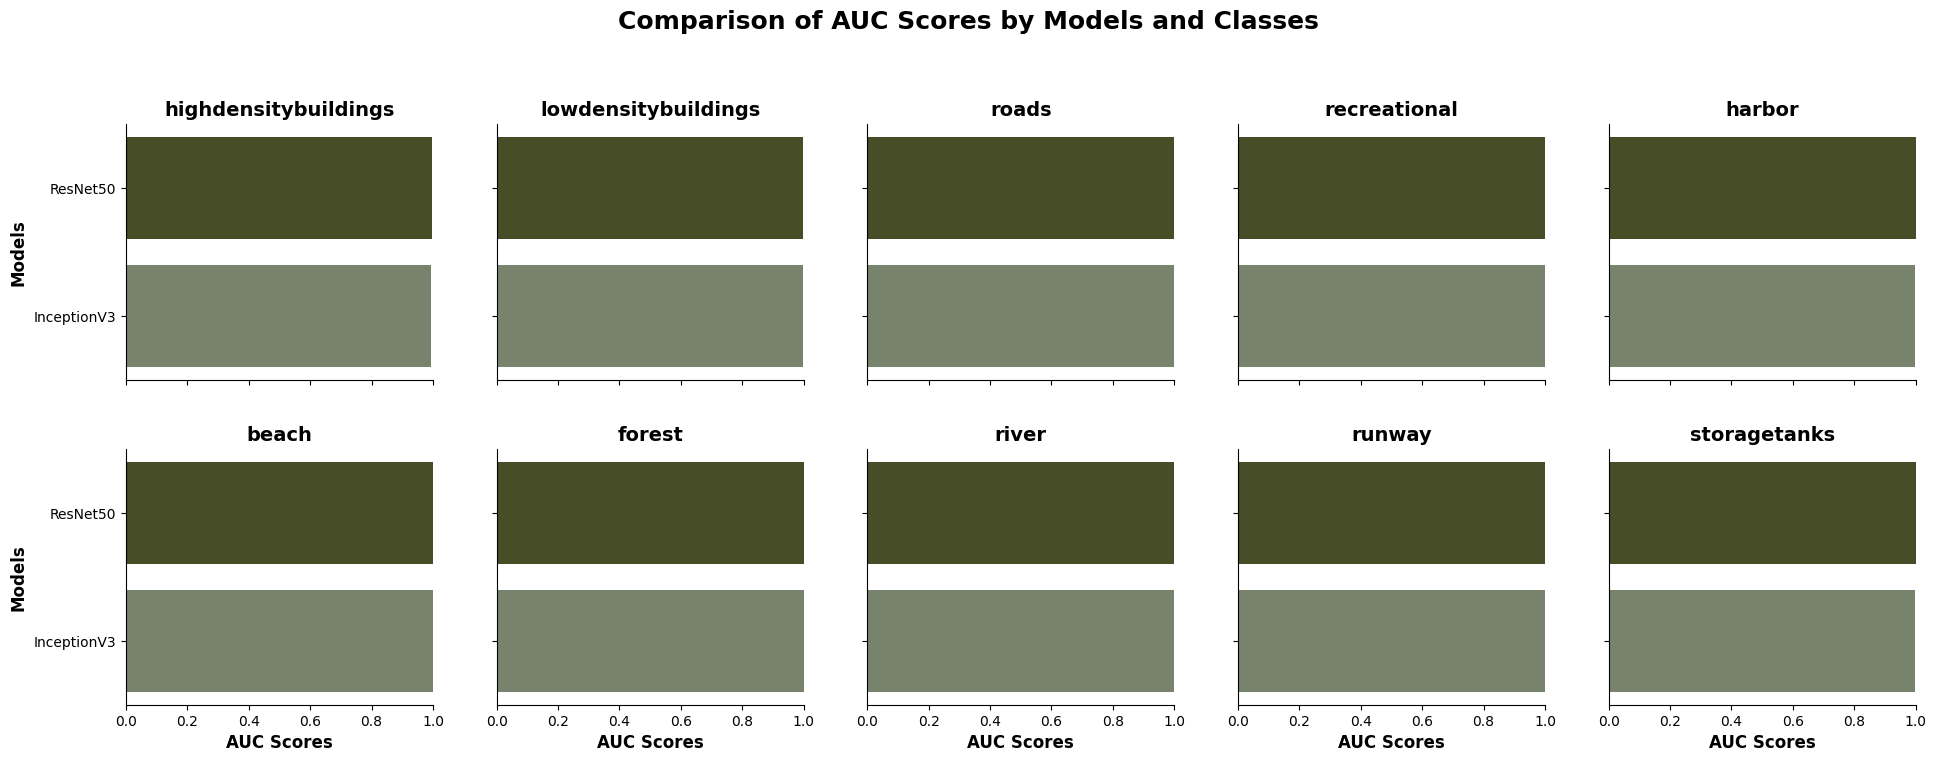

In [ ]:
g = sns.catplot(data=df_auc, x='auc', y='models', col='label', col_wrap=5, kind='bar', hue='models', palette=['#4B5320', '#78866B'], height=4, legend=False)
g.fig.subplots_adjust(top=0.9, hspace = 0.8)
g.fig.suptitle('Comparison of AUC Scores by Models and Classes', size=18, fontweight='bold')
g.set_axis_labels('AUC Scores', 'Models', size=12, fontweight='bold')
g.set_titles('{col_name}', size=14, fontweight='bold')
g.set(xlim=(0, 1))
g.fig.tight_layout(pad = 3.0)
plt.show()

As shown in the various plots above, both models have performed exceptionally on the landuse dataset, achieving close to perfect AUC scores. ResNet50 achieved perfect AUC scores of 1.0 in two classes, specifically runway and harbour.  

In [ ]:
# Confidence Level
def conf_levels(predprob, predclass):
    # Set a condition to filter for records that were incorrectly predicted
    condition = (predclass != y_true)

    # Get the highest percentage out of all classes
    confidence = np.max(predprob, axis=1)

    # Filter for records that were incorrectly predicted
    incorrect_confidence = confidence[condition]

    # Store values in a list
    mean_confidence = []
    for num in range(0, 10):
        # Calculate average confidence of model in its predictions
        mean_val = np.mean(confidence[y_true == num])
        mean_confidence.append(f'{mean_val*100:.2f}%')

    # Create a dataframe to display values
    class_names = pd.Series(CLASSES)
    mean_confidence = pd.Series(mean_confidence)
    df_confidence = pd.concat([class_names, mean_confidence], axis=1)
    df_confidence.columns = ['Class', 'Confidence Level']
    df_confidence.sort_values('Confidence Level', key=lambda x: x.str.rstrip('%').astype(float), ascending=False, inplace=True)

    ## For plotting incorrectly predicted image samples
    # Actual class of records for incorrectly classified samples
    true_class = y_true[condition]
    # Incorrectly predicted class
    incorrect_pred = predclass[condition]

    # Filter for incorrect val images
    X_test_incorrect = X_test[condition]
    X_test_incorrect = X_test_incorrect.reshape(incorrect_pred.shape[0], 100, 100, 3)

    # Define number of samples
    num_samples = 30
    # Choose samples randomly
    random_idxpred = np.random.choice(incorrect_pred.shape[0], num_samples, replace=False)

    # Plot samples
    fig, axes = plt.subplots(5, 5, figsize=(15, 15))
    fig.suptitle('Predicted vs Actual Class Labels', size = 20,  y = 1.05)

    for idx, ax in zip(random_idxpred, axes.flatten()):
      ax.imshow(X_test_incorrect[idx], cmap='gray')
      ax.set_title(f'Actual: {CLASSES[true_class[idx]]}\nPredicted: {CLASSES[incorrect_pred[idx]]}\
        \n({incorrect_confidence[idx]*100:.2f}%)', color='red')
      ax.axis('off')
    plt.tight_layout()
    plt.show()

    return df_confidence

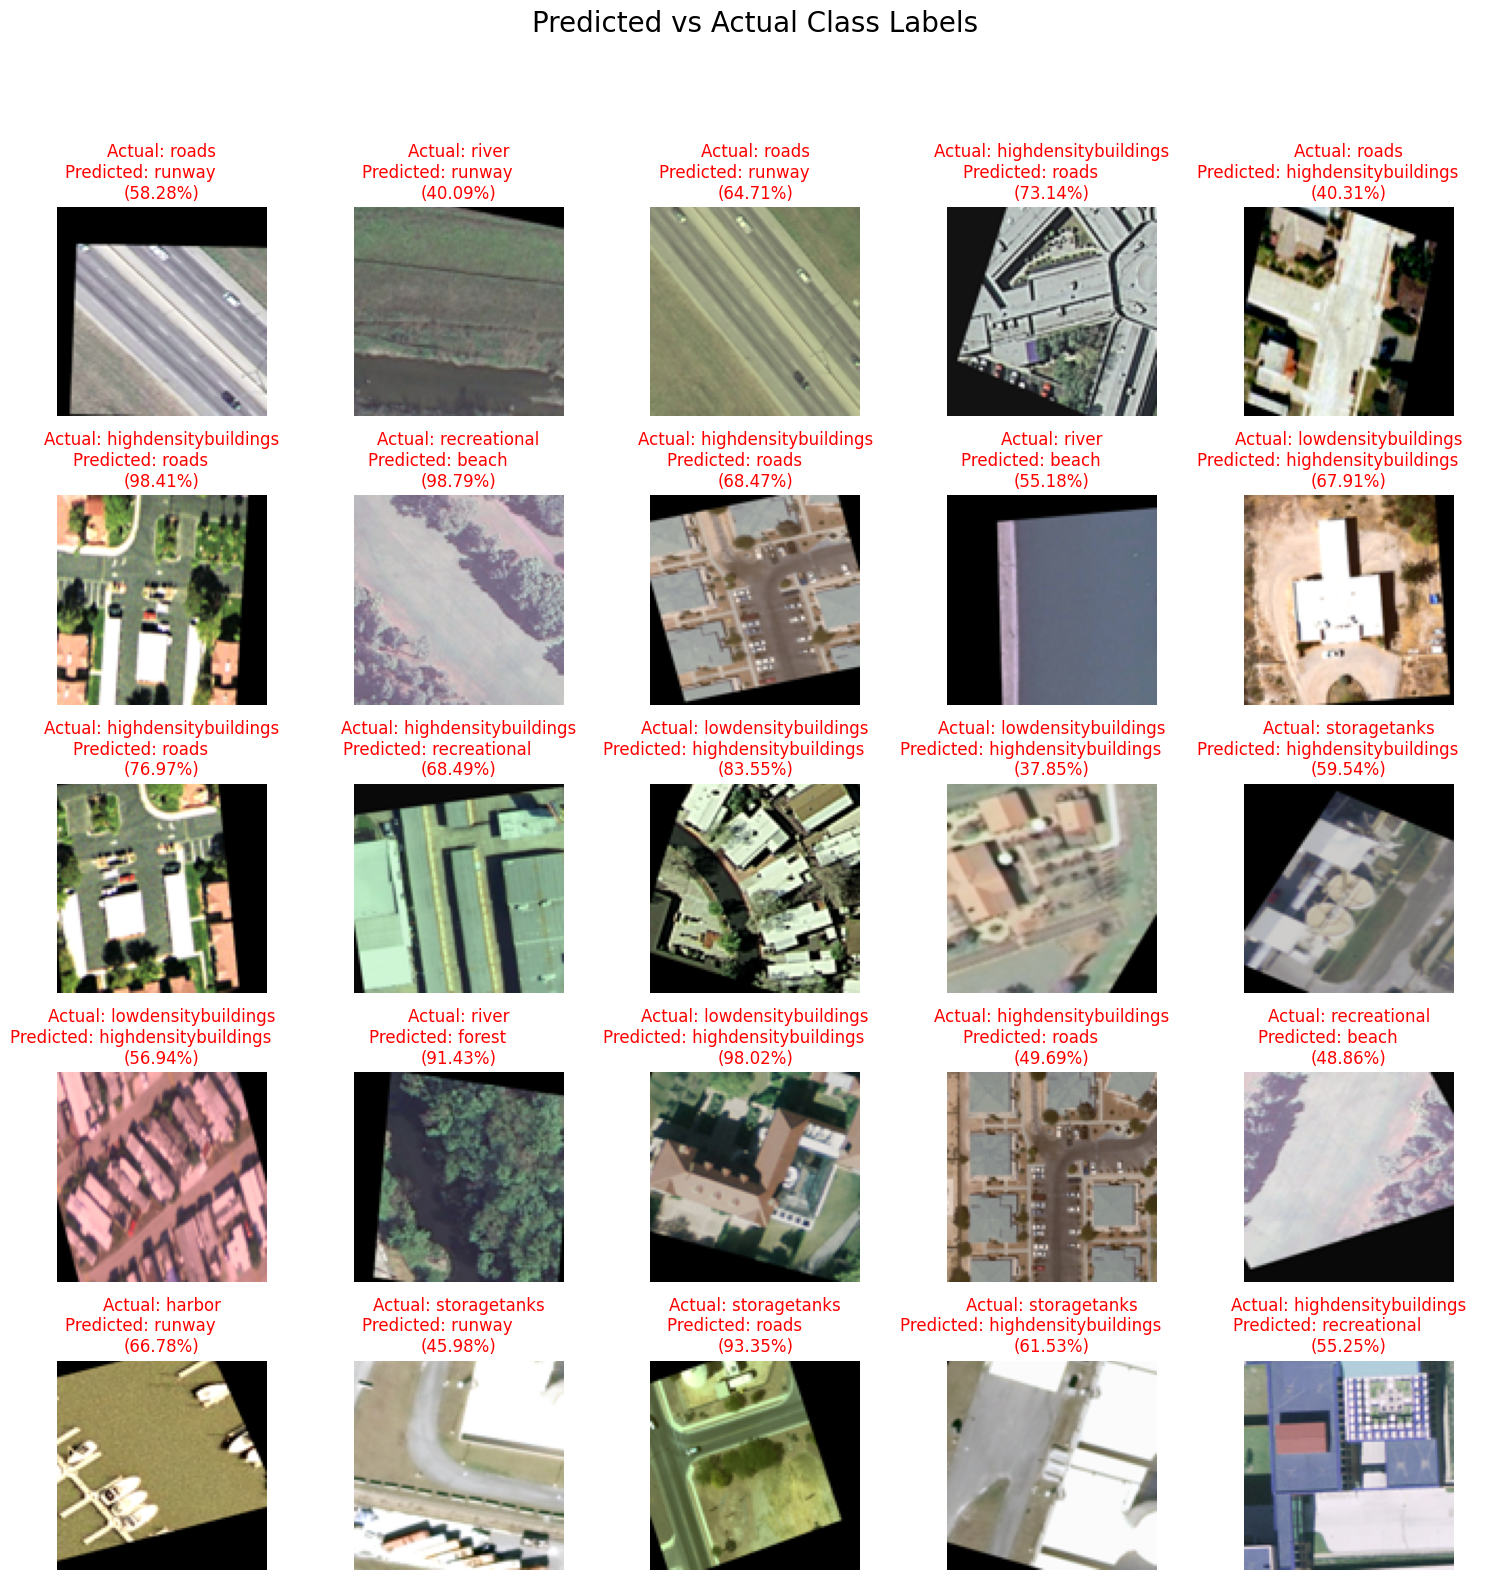

In [ ]:
df_confidenceRN50 = conf_levels(predprobas[model_dict['ResNet50']], predictions[model_dict['ResNet50']])

In [ ]:
df_confidenceRN50

Class Confidence Level
6                forest           99.73%
8                runway           99.73%
4                harbor           99.15%
3          recreational           98.45%
2                 roads           98.24%
5                 beach           97.46%
0  highdensitybuildings           96.14%
9          storagetanks           95.17%
1   lowdensitybuildings           92.46%
7                 river           92.10%

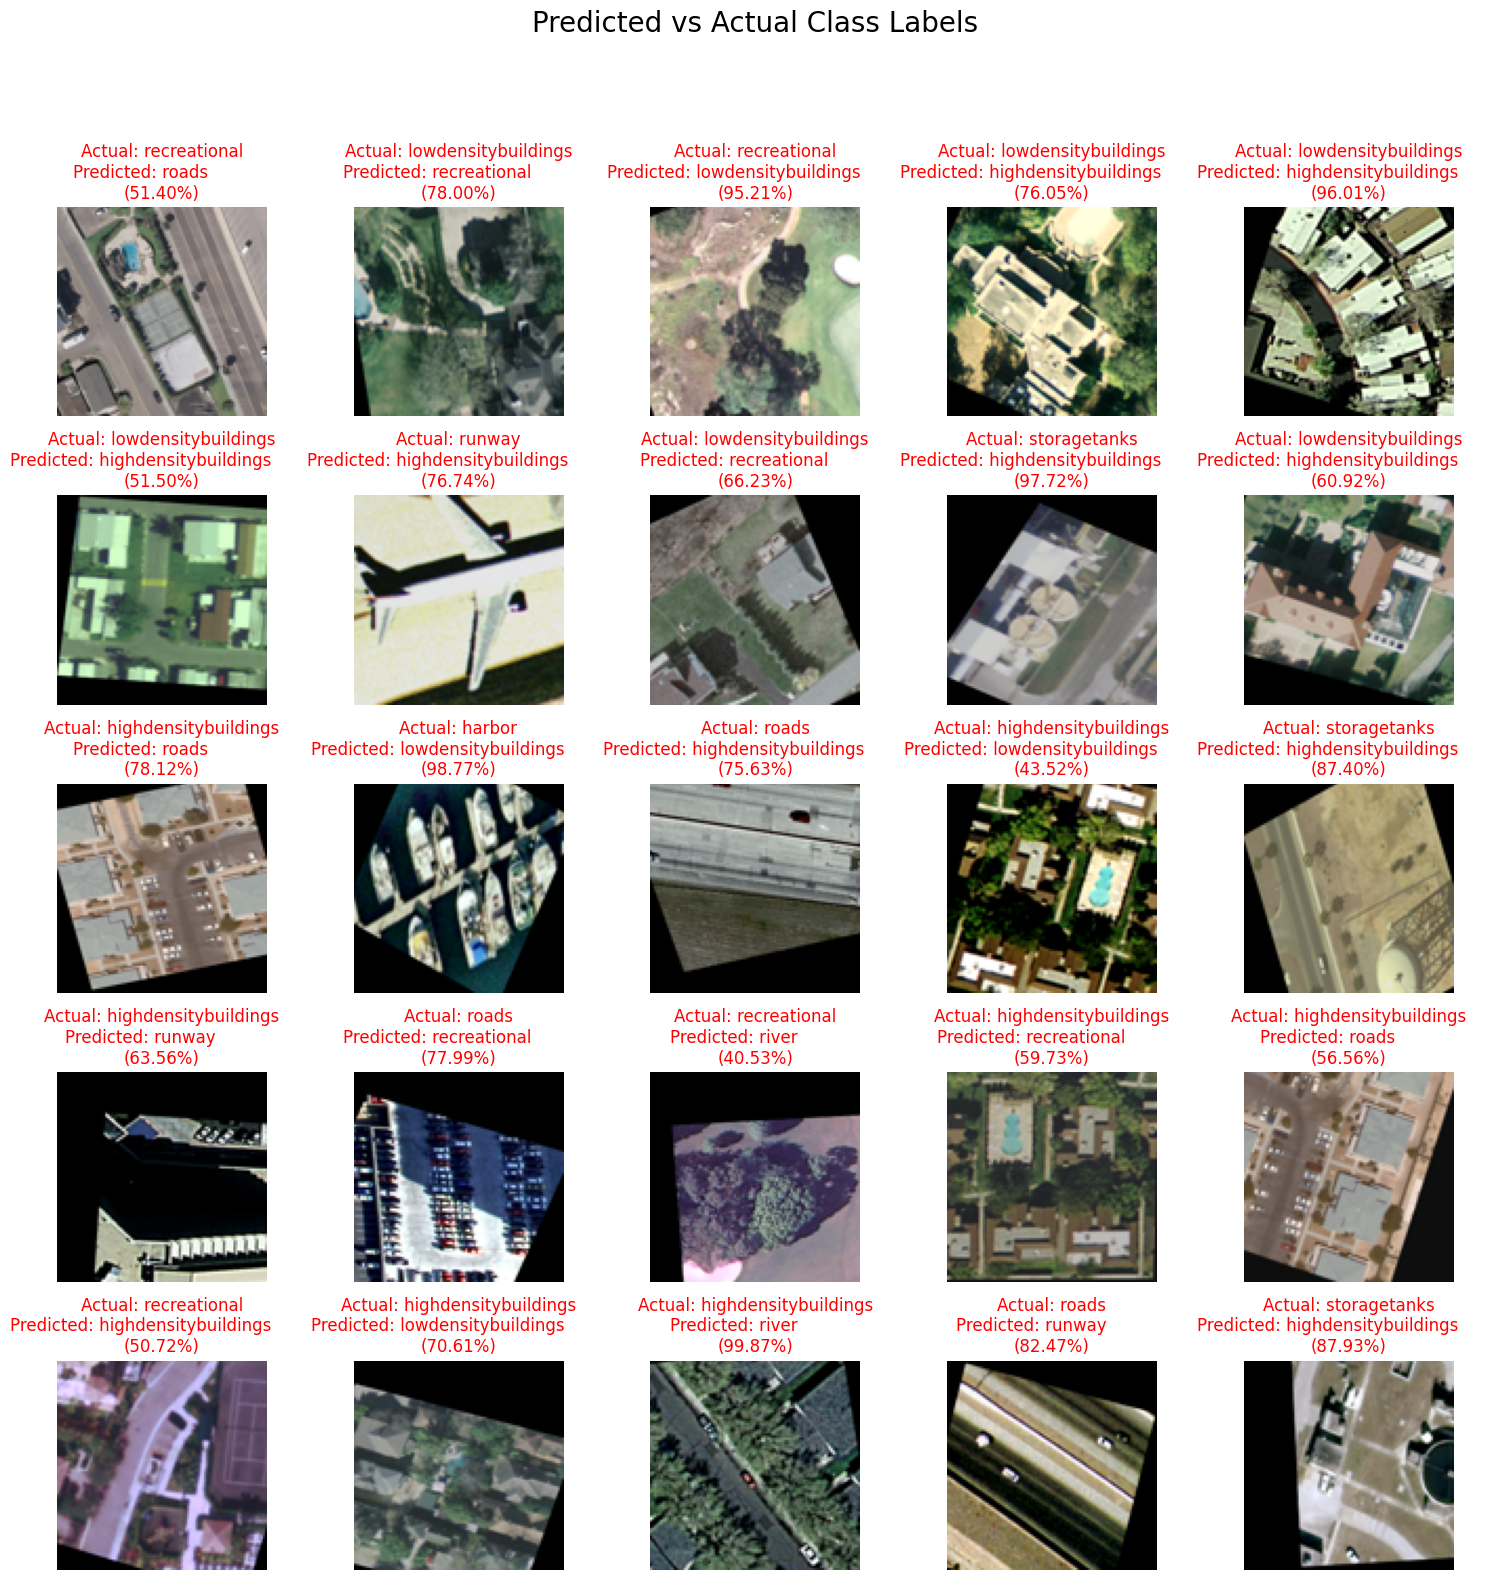

In [ ]:
df_confidenceIV3 = conf_levels(predprobas[model_dict['InceptionV3']], predictions[model_dict['InceptionV3']])

In [ ]:
df_confidenceIV3

Class Confidence Level
4                harbor           99.36%
2                 roads           98.40%
6                forest           98.23%
8                runway           97.80%
5                 beach           97.53%
3          recreational           95.86%
1   lowdensitybuildings           94.84%
0  highdensitybuildings           94.40%
7                 river           94.11%
9          storagetanks           93.66%

When comparing the confidence levels per class of each model, Inception V3 is most confident in classifying images from the harbour (99.36%), road (98.40%), and forest classes (98.23%) and least confident in predicting images the high-density buildings (94.40%), river (94.11%), and forest classes (93.66%). Similarly, ResNet50 was also very confident in making predictions on the forest (99.73%) and harbour classess (99.15%), and not so confident in predicting rivers (92.10%). However, ResNet50 is slighty more confident in classifying runways (99.73%) and slightly less confident in predicting low-density buildings (92.46%). <br><br>

Overall, ResNet50 has performed slightly better than Inception V3 in terms of accuracy and AUCROC scores, although the difference is very marginal.


